In [1]:
# 结合筛选出的星系，做出spaxel分布图
#######################################

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy
from os.path import join
import math
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot
import warnings
warnings.filterwarnings('ignore')    # 不显示warning信息

new_ra_dec = np.loadtxt('/root/cosmos/data/nair_ra_dec_ba.txt')

# 读取nsa与manga的匹配数组
nsa_vs_manga = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/nsa101_vs_manga.dat")

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
basic_manga = copy.copy(vac0[1].data)

# load the data of NASA-Sloan catalog v1 0 1
nsa101 = fits.open('/root/cosmos/data/nsa_v1_0_1.fits') 
basic_nsa = nsa101[1].data
nsa_ba = copy.copy(basic_nsa['PETRO_BA90'])
nsa_mass1 = copy.copy(basic_nsa['ELPETRO_MASS'])    #Stellar mass from K-correction fit (use with caution) for elliptical Petrosian fluxes
nsa_mass2 = copy.copy(basic_nsa['SERSIC_MASS'])    #Stellar mass from K-correction fit (use with caution) for Sersic fluxes
#ELPETRO_BA
# http://skyserver.sdss.org/dr15/en/tools/search/IQS.aspx
# 衡量星系的年龄大小的量 fracDeV<0.7
fracDeV = np.loadtxt('lalala_manga_fradeV.txt')

# https://www.sdss.org/dr12/algorithms/classify/#photo_adaptive
# http://skyserver.sdss.org/dr15/en/help/docs/QS_UserGuide.aspx#SAS
# 筛选倾斜程度，椭圆的长轴短轴为a b
# 计算出每个星系的a b
# b/a>=0.3
#q_u = np.loadtxt('manga_Q_U_4675.txt')
#b_over_a = 2/((q_u[:,0]**2+q_u[:,1]**2)**0.5+1)-1


#########################################
# 去重
tmp_num_ij = nsa_vs_manga    # 临时存储一下，防止改动
#tmp_num_ij = tmp_num_ij[np.where((old_same_gal[:,0]==1) & (~np.isnan(nsa_ba)) & (tmp_num_ij[:,0]!=-999))]    # 筛选出未重复的星系编号 & 剔除无效数据nan
tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 剔除nsa_b/a无效数据nan
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 将匹配到的有效位置提出，-999为初始值
a,last_num = np.unique(tmp_num_ij[:,0],return_index=True)    # 第一列nsa数据去重
tmp_num_ij = tmp_num_ij[last_num]
#tmp_num_ij = tmp_num_ij[np.where(~np.isnan(nsa_ba))]    # 
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列manga数据去重
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)    #最后得到了最终版的nsa_vs_manga数组位置
######################################

b_over_a = nsa_ba[tmp_num_ij[:,0]]    # 根据数组位置提出nsa_b/a
#nsa_mass = nsa_mass1[tmp_num_ij[:,0]]

# 星系质量筛选
# stellar mass > 10^9 太阳质量
#glo_mass_id = basic_manga['PHOTOMETRIC_MASS'] > 10e8
manga_mass = basic_manga['PHOTOMETRIC_MASS']
manga_mass = manga_mass[tmp_num_ij[:,1]]    # 匹配数组维度
#glo_mass_id = glo_mass_id[tmp_num_ij[:,1]]    # 匹配数组维度
glo_mass_id = np.where(manga_mass>1e9)

# 星系star-forming区域筛选
# sfr spaxels >= 20
#plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/plfu_sfr_spaxel.dat")
plfu_sfr = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/plate_ifu_spaxel_v2.0.dat")
plfu_sfr = plfu_sfr[tmp_num_ij[:,1]]    # 匹配数组维度
sfr_id = np.where(plfu_sfr[:,2]>=20)

fra_b_over_a = np.zeros([4675,3])
fra_b_over_a[:,0] = fracDeV
fra_b_over_a = fra_b_over_a[tmp_num_ij[:,1]]
fra_b_over_a[:,1] = b_over_a
manga_id = tmp_num_ij[:,1]

# 开始筛选，在第三列进行判断计数
fra_b_over_a[np.where(fra_b_over_a[:,0]<0.7),2] += 1    # fracDeV筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==1)
print("筛选fracDeV，得到late-type星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # b/a筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==2)
print("筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数： ",np.shape(sel_galaxy)[1])

fra_b_over_a[np.where(glo_mass_id),2] += 1    # 星系总质量筛选
fra_b_over_a[sfr_id,2] += 1    # 星系形成区域筛选

sel_galaxy = np.where(fra_b_over_a[:,2]==4)    # 四次筛选结果

print("不考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\n替换nair_ba之前，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))


#########################################################
# 第五次筛选：manga与nair匹配的星系中，nair_b/a < manga_b/a

# 读取manga vs nair 匹配数组
last_same_gal = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_vs_nair.dat")
# 去重
tmp_num_ij = last_same_gal    # 临时存储一下，防止改动
tmp_num_ij = tmp_num_ij[np.where(tmp_num_ij[:,0]!=-999)]    # 筛选出未重复的星系编号
#tmp_num_ij = tmp_num_ij[np.where(old_same_gal[:,0]==1)]    # 筛选出未重复的星系编号
#a,num_last_same_gal = np.unique(last_same_gal[np.where(old_same_gal[:,0]==1),0],return_index=True)    # 第一列sdss数据去重
a,last_num = np.unique(tmp_num_ij[:,1],return_index=True)    # 第二列nair数据去重，last_num为最后编号
tmp_num_ij = tmp_num_ij[last_num]
tmp_num_ij = tmp_num_ij.astype(np.int64)

# manga数组编号为tmp_num_ij[:,0]
# nair catalog 的b/a为nair_ba
nair_ba = new_ra_dec[tmp_num_ij[:,1],2]    #nair catalog 中的b/a
# 剔除999999坏数据
tmp_num_ij = tmp_num_ij[np.where(nair_ba!=999999)]
manga_vs_nair_id = tmp_num_ij    # 最终版的manga_vs_nair
nair_ba = nair_ba[np.where(nair_ba!=999999)]    # nair catalog 的 b/a




##################################################################################
# nair_b/a中较小的值
manga_vs_nair_id = manga_vs_nair_id[np.where(nair_ba<=0.1)]    # 数组位置进行同步筛选
nair_ba = nair_ba[np.where(nair_ba<=0.1)]

manga_ba = fra_b_over_a[:,1]    # 原始b/a，数据来源于nsa_v101
#manga_id前面已赋值4561个星系，即所在的数组位置信息
k=0
# for 循环将manga_ba的值替换成nair中b/a较小的值
for i in range(0,manga_ba.size):    # 循环nsa
    for j in range(0,nair_ba.size):    # 循环nair
        if (manga_id[i]==manga_vs_nair_id[j,0])&(manga_ba[i] > nair_ba[j]):
        #if (manga_id[i]==manga_vs_nair_id[j,0]):
            #manga_ba[i] = nair_ba[j]
            k+=1
            fra_b_over_a[i,2]+=66
        #if manga_id[i]==manga_vs_nair_id[j,1]:
            #fra_b_over_a[i,2]+=1

fra_b_over_a[:,1] = manga_ba    # 替换完成
fra_b_over_a[np.where(fra_b_over_a[:,1]>=0.3),2] += 1    # 加入nair的b/a之后的筛选
sel_galaxy = np.where(fra_b_over_a[:,2]==5)    # 五次筛选结果

# 筛选出的星系的manga数组位置
num_sel_gal = manga_id[sel_galaxy]    # 筛选出的星系的manga数组位置

print("替换nair_ba之后，b/a平均值 = ",np.mean(fra_b_over_a[:,1]))
print("\n考虑nair catalog时：","\n已从 manga 4675 个星系中找出 ",np.shape(sel_galaxy)[1]," 个星系","\n距论文中的 1222 个星系还差  ",np.shape(sel_galaxy)[1]-1222,"个")
print("\nnair与manga重叠匹配到 ",k," 个星系")

INFO: No release version set. Setting default to DR15
筛选fracDeV，得到late-type星系个数：  2238
筛选fracDeV+初步b/a，得到late-type+不是很倾斜的星系个数：  2103
不考虑nair catalog时： 
已从 manga 4675 个星系中找出  1400  个星系 
距论文中的 1222 个星系还差   178 个

替换nair_ba之前，b/a平均值 =  0.6989220308384543
替换nair_ba之后，b/a平均值 =  0.6989220308384543

考虑nair catalog时： 
已从 manga 4675 个星系中找出  1400  个星系 
距论文中的 1222 个星系还差   178 个

nair与manga重叠匹配到  0  个星系


In [2]:
# num_sel_gal：筛选得到的接近1222个星系的数组位置
# spaxel_data：获取的所有的spaxel的数据
# 0: spaxel所在的星系的数组位置
# 1: spaxel在2800数组中的位置
# 2: 星系中的y位置
# 3: 星系中的x位置
# 4: spaxel's surface mass density
# 5: nii 6584
# 6: oiii 5007
# 7: oii 3729
# 8: oii 3726
# 9: log(Oiii/Oii)
# 10: log(nii/Oii)
# 11: E(B-V)

# 载入数据
spaxel_data = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/galid_ij_den_NO_logOiiioii_logniioii_star_forming_v2.0.dat")
# spaxel_data = galid_den_NO
# spaxel_ha_hb = np.loadtxt("/root/.jupyter/cosmos/code_git/Metallicity-deviation/tmp_storage/manga_sf_spaxel_flux.dat")
# spaxel_ha_hb = galid_den_NO[:,[5,6]]

lala = np.where(spaxel_data[:,0]!=-9999)
spaxel_data = spaxel_data[lala]    # 剔除无效数据【spaxel数据为空】

sel_spaxel = np.zeros([spaxel_data[:,0].size,1])    # 计数筛选数组
for i in range(0,num_sel_gal.size):
    id_sel = (num_sel_gal[i]==spaxel_data[:,0])
    #id_sel = (lalala[:,0]==num_sel_gal[i])
    sel_spaxel[id_sel] = +1

# 按照筛选出的1222个星系挑选数据
spaxel_data = spaxel_data[np.where(sel_spaxel>=1)[0]]
# spaxel_ha_hb = spaxel_ha_hb[np.where(sel_spaxel>=1)[0]]

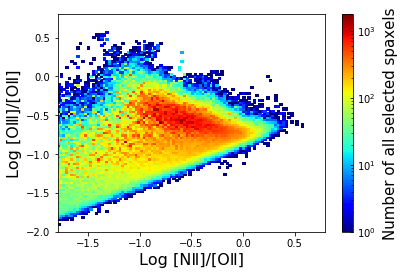

In [59]:
############################################
####### 消光修正 extinction correction #####
############################################

# 元素的波长设定
# ha_6564    hb_4862    nii_6585    oii_3727    oii_3729    oiii_5008    
ha_lam = 0.6564
hb_lam = 0.4862
nii_lam = 0.6585
oii7_lam = 0.3727
oii9_lam = 0.3729
oiii_lam = 0.5008

# 获取元素的flux
# %xdel ha
# %xdel hb
# %xdel nii
# %xdel oii7
# %xdel oii9
# %xdel oiii
ha = spaxel_data[:,5]
hb = spaxel_data[:,6]
nii = spaxel_data[:,7]
oii7 = spaxel_data[:,10]
oii9 = spaxel_data[:,9]
# oii9 = spaxel_data[:,7]*0
oiii = spaxel_data[:,8]

E_BV = spaxel_data[:,11]    # 获取E(B-V)
Es_BV = 0.44*E_BV    # 计算Es(B-V)

# 判断是否 ha/hb >= 2.86，若是，则修正；若不是，则不管
# %xdel ha_over_hb
ha_over_hb = ha/hb    # 计算ha/hb
tmp_id = np.where(ha_over_hb>=2.86)    # 找出 ha/hb>=2.86 的数组位置
Rv = 4.05    # 论文中的Rv取4.05
def flux_coeff(tmp_lamda):
    
    k_lamda = 2.659*(-2.156+1.509/tmp_lamda-0.198/tmp_lamda**2+0.011/tmp_lamda**3)+Rv
    # 修正系数
    x2 = 0.4*Es_BV*k_lamda
    flux_coff = np.power(10,x2)
    
    return flux_coff

# 进行flux的修正！！！
nii[tmp_id] = nii[tmp_id]*flux_coeff(nii_lam)[tmp_id]
oii7[tmp_id] = oii7[tmp_id]*flux_coeff(oii7_lam)[tmp_id]
oii9[tmp_id] = oii9[tmp_id]*flux_coeff(oii9_lam)[tmp_id]
oiii[tmp_id] = oiii[tmp_id]*flux_coeff(oiii_lam)[tmp_id]


# 计算元素的flux之比，并log
# %xdel lg_oiii_oii
# %xdel lg_nii_oii
lg_oiii_oii = np.log10(oiii/(oii7+oii9))
lg_nii_oii = np.log10(nii/(oii7+oii9))
############################
####### 消光修正结束 #######
############################

# 画图
# %xdel y
# %xdel x
y = lg_oiii_oii
x = lg_nii_oii

fig = plt.figure()    # 设定图形大小
ax1 = fig.add_subplot(111)    # 设定子图，调整位置

# hist2d画图
xbins,ybins,hist,cax = ax1.hist2d(x,y,bins=100,range=[[-1.8,0.8],[-2,0.8]],cmap='jet',norm=mpl.colors.LogNorm()) 
# xbins,ybins,hist,cax = plt.hist2d(x,y,bins=100,range=[[-1.8,0.8],[-2,0.8]],cmap='jet',norm=mpl.colors.LogNorm()) 
# ax1.set_aspect(1)
plt.xlabel('Log [NⅡ]/[OⅡ]',fontsize=16)    # x轴标签
plt.ylabel('Log [OⅢ]/[OⅡ]',fontsize=16)    # y轴标签
# colorbar调整
cbar = fig.colorbar(cax)
cbar.ax.tick_params(which='both',direction='in')
cbar.set_label("Number of all selected spaxels",fontsize=15,labelpad=8)
plt.show() 
# b = np.argwhere(np.isnan(a[:,8]))
# c = np.unique(a[b,0]).astype(int)
# print(lalala.shape)
# print("max = ",np.max(lalala[:,2]))
# print("min = ",np.min(lalala[:,2]))
# print(lalala[20:40,2])

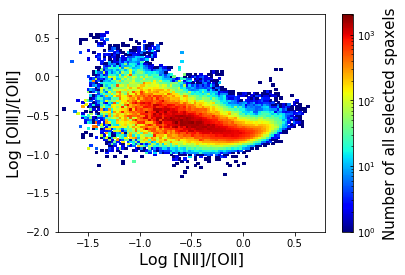

In [5]:
### 第一次运行